## COMMUNITY DETECTION USING NETWORKX

The ultimate goal in studying networks is to better understand the behavior of the systems they represent. For instance, we study social networks to better understand the nature of social interactions and their implications for human experience, commerce, the spread of disease, and the structure of society. We study the Internet to better understand the flow of data traffic or why communications protocols function the way they do or how we might change the network to make it perform better. We study biochemical networks like metabolic networks because we hope it will lead to a better understanding of the complex chemical processes taking place in the cell and perhaps even to new therapies for disease or injury.

The problem of finding groups of nodes in networks is called community detection. Simple though it is to describe, community detection turns out to be a challenging task, but a number of methods have been developed that return good results in practical situations.

We describe below how NetworkX can be used to analyze communities in a network.



In [1]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
# get reproducible results
import random
from numpy import random as nprand
random.seed(123)
nprand.seed(123)

### THE UNAVOIDABLE KARATE CLUB EXAMPLE

The most direct way to tell how many communities there is in a network is like so:

In [2]:
G_karate = nx.karate_club_graph()

# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G_karate), key=len, reverse=True)

# Count the communities
print(f"The karate club has {len(communities)} communities.")

The karate club has 3 communities.


The output of the community detection consists of sets of vertex numbers (set of sets). 

If we wish to visualize this we need to define a few utilities. 

The methods simply assign the community number to the nodes and edges:

In [4]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

With this we now assign the community info to the elements:

In [5]:
# Set node and edge communities
set_node_community(G_karate, communities)
set_edge_community(G_karate)
node_color = [get_color(G_karate.nodes[v]['community']) for v in G_karate.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

A little plot now gives a better idea of how the karate club communities are:

In [7]:
karate_pos = nx.spring_layout(G_karate)
plt.rcParams.update({'figure.figsize': (15, 10)})

# Draw external edges
nx.draw_networkx(
    G_karate,
    pos=karate_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")

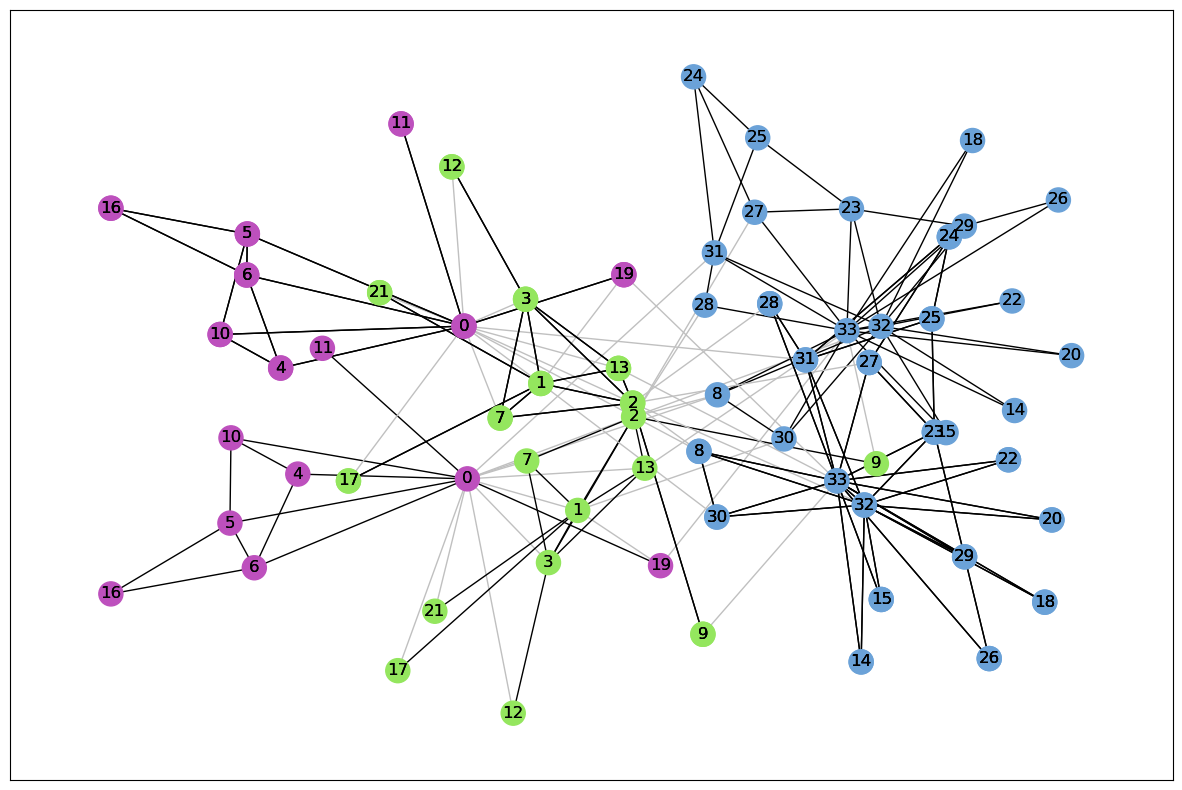

In [9]:
# Draw nodes and internal edges
nx.draw_networkx(
    G_karate,
    pos=karate_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)

plt.show()

### A LARGER EXAMPLE
We’ll use the dataset from SNAP; J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.

In [12]:
data_path = '../data/facebook/facebook_combined.txt'
G_social = nx.read_edgelist(data_path)

To get an idea, let’s render it:

In [13]:
pos = nx.spring_layout(G_social, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G_social,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)
plt.show()

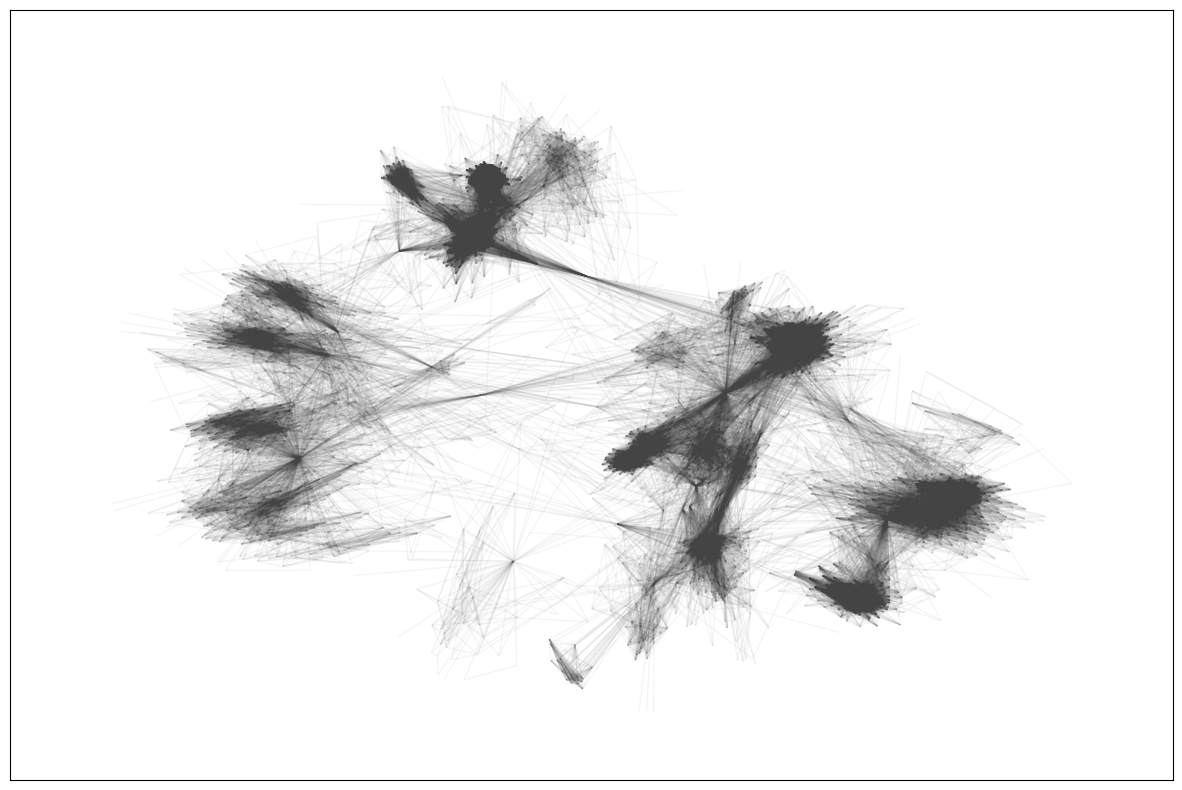

In [14]:
plt.show()

There are 13 communities in this network:

In [15]:
communities = sorted(nxcom.greedy_modularity_communities(G_social), key=len, reverse=True)
len(communities)

16

and like above we can render them with the same utility methods

In [16]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.style.use('dark_background')

# Set node and edge communities
set_node_community(G_social, communities)
set_edge_community(G_social)

# Set community color for internal edges
external = [(v, w) for v, w in G_social.edges if G_social.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_social.edges if G_social.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(G_social.nodes[v]['community']) for v in G_social.nodes]

# external edges
nx.draw_networkx(
    G_social,
    pos=pos,
    node_size=0,
    edgelist=external,
    edge_color="silver",
    node_color=node_color,
    alpha=0.2,
    with_labels=False)
    
# internal edges
nx.draw_networkx(
    G_social, pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.05,
    with_labels=False)

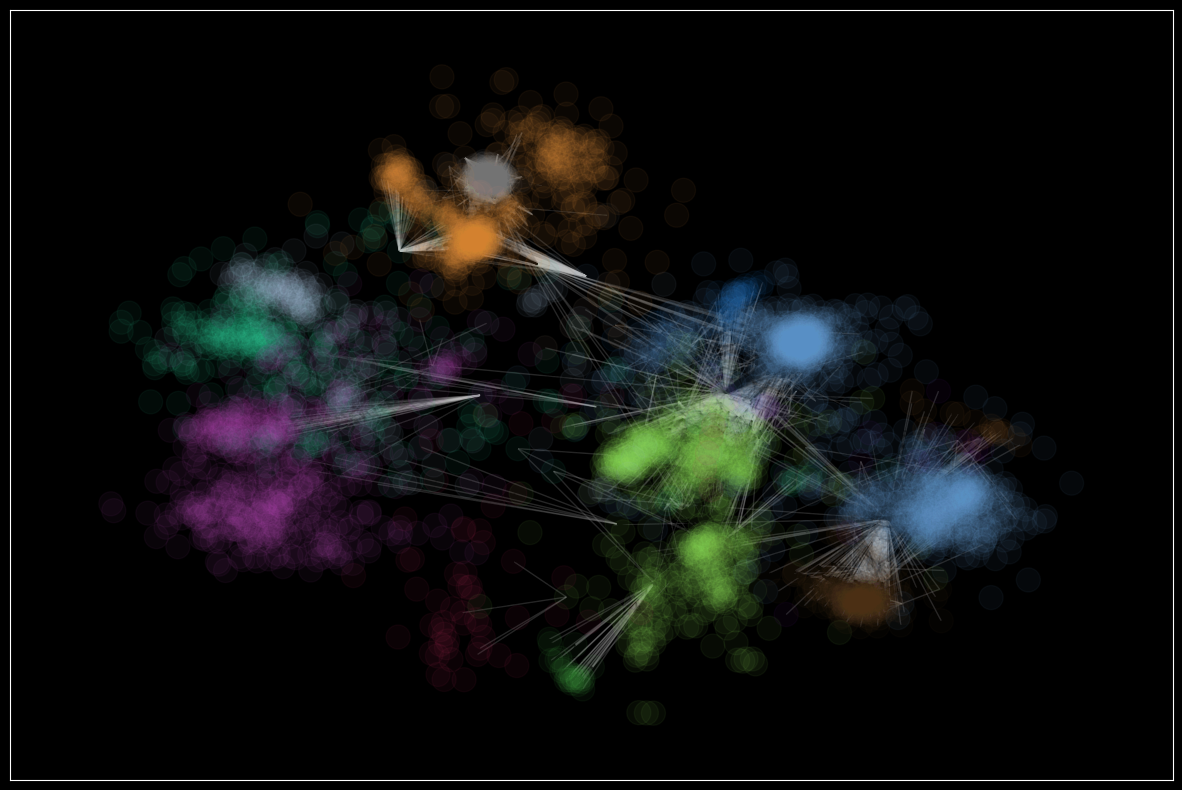

In [17]:
plt.show()

## GIRVAN-NEWMAN COMMUNITY DETECTION

The Girvan–Newman algorithm detects communities by progressively removing edges from the original network. 
The connected components of the remaining network are the communities. 
Instead of trying to construct a measure that tells us which edges are the most central to communities, the Girvan–Newman algorithm focuses on edges that are most likely “between” communities.
Applying it to the small karate club:

In [18]:
result = nxcom.girvan_newman(G_karate)
communities = next(result)
len(communities)

2

and we see that this method detects only two communities unlike the first method. 

Using the very same code as before we can render the result

In [19]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

# Set node and edge communities
set_node_community(G_karate, communities)
set_edge_community(G_karate)

# Set community color for nodes
node_color = [get_color(G_karate.nodes[v]['community']) for v in G_karate.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] > 0]
internal_color = [get_color(G_karate.edges[e]['community']) for e in internal]
karate_pos = nx.spring_layout(G_karate)

# Draw external edges
nx.draw_networkx(
    G_karate, pos=karate_pos, node_size=0,
    edgelist=external, edge_color="#333333", with_labels=False)

# Draw nodes and internal edges
nx.draw_networkx(
    G_karate, pos=karate_pos, node_color=node_color,
    edgelist=internal, edge_color=internal_color)

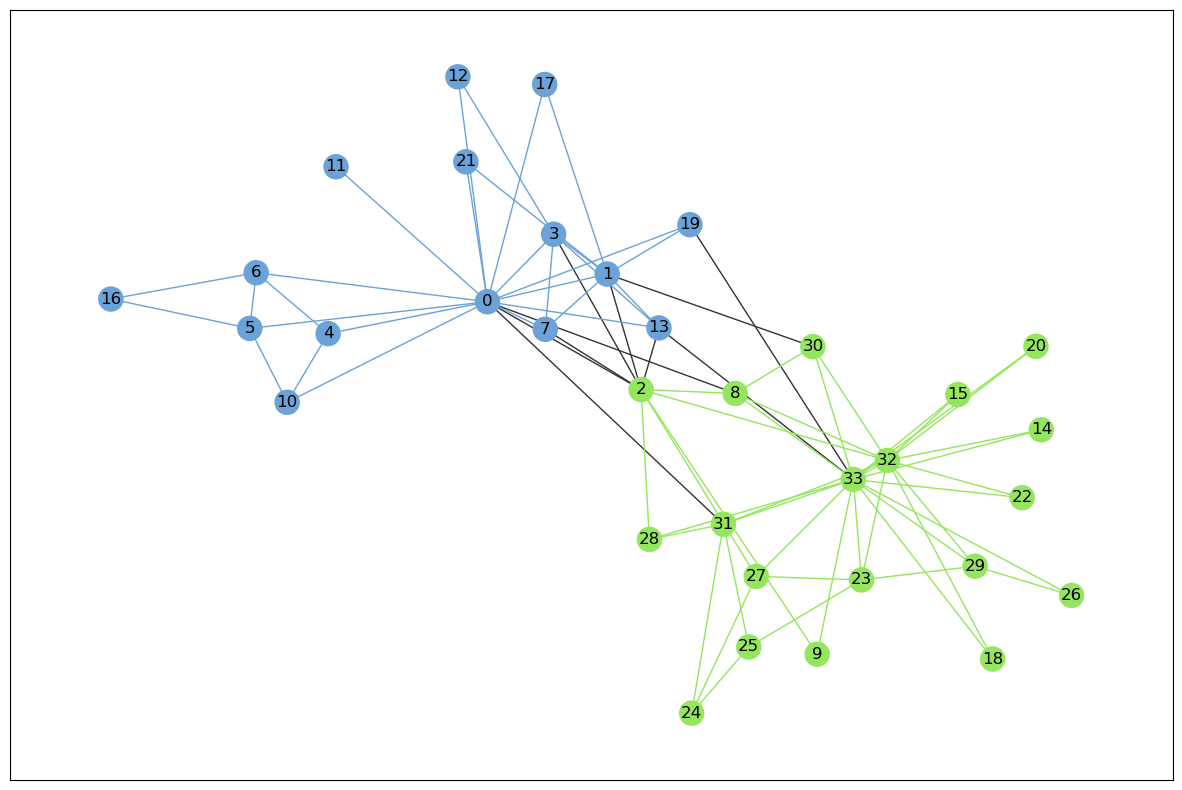

In [20]:
plt.show()

## CLIQUES

A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent; that is, its induced subgraph is complete. Cliques are in a way tight communities where every nodes is connected to every other.
Let’s look at the largest clique in the karate club:



In [21]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
cliques = list(nx.find_cliques(G_karate))
max_clique = max(cliques, key=len)
node_color = [(0.5, 0.5, 0.5) for v in G_karate.nodes()]
for i, v in enumerate(G_karate.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
nx.draw_networkx(G_karate, node_color=node_color, pos=karate_pos)

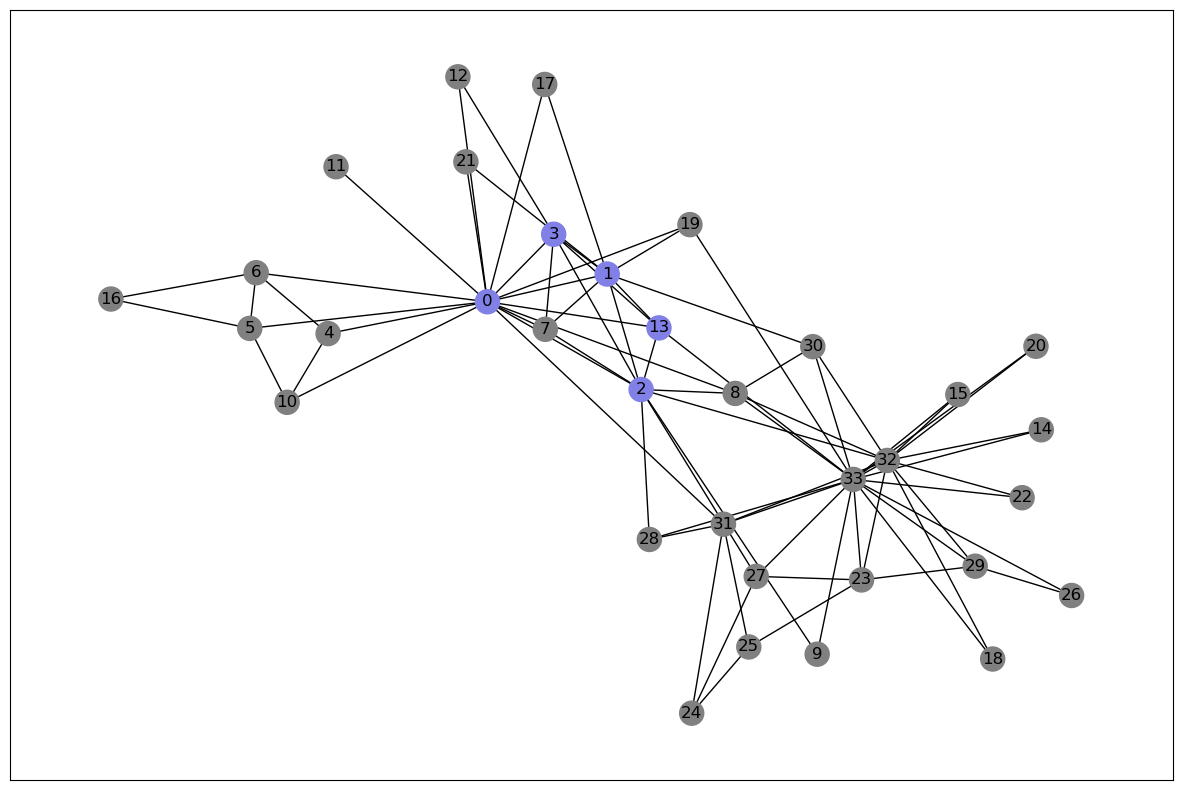

In [22]:
plt.show()

## K-CORES

A k-core of a graph G is a maximal connected subgraph of G in which all vertices have degree at least k. 
Equivalently, it is one of the connected components of the subgraph of G formed by repeatedly deleting all vertices of degree less than k. 
If a non-empty k-core exists, then, clearly, G has degeneracy at least k, and the degeneracy of G is the largest k for which G has a k-core.


In [23]:
# cores with at lest degree 30
G_core_30 = nx.k_core(G_social, 30)

# similarly, with at least degree 60
G_core_60 = nx.k_core(G_social, 60)

# Visualize network and k-cores
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.style.use('dark_background')
pos = nx.spring_layout(G_social, k=0.1)
nx.draw_networkx(G_social, pos=pos, node_size=0, edge_color="#333333", alpha=0.05, with_labels=False)
nx.draw_networkx(G_core_30, pos=pos, node_size=0, edge_color="green", alpha=0.05, with_labels=False)
nx.draw_networkx(G_core_60, pos=pos, node_size=0, edge_color="red", alpha=0.05, with_labels=False)

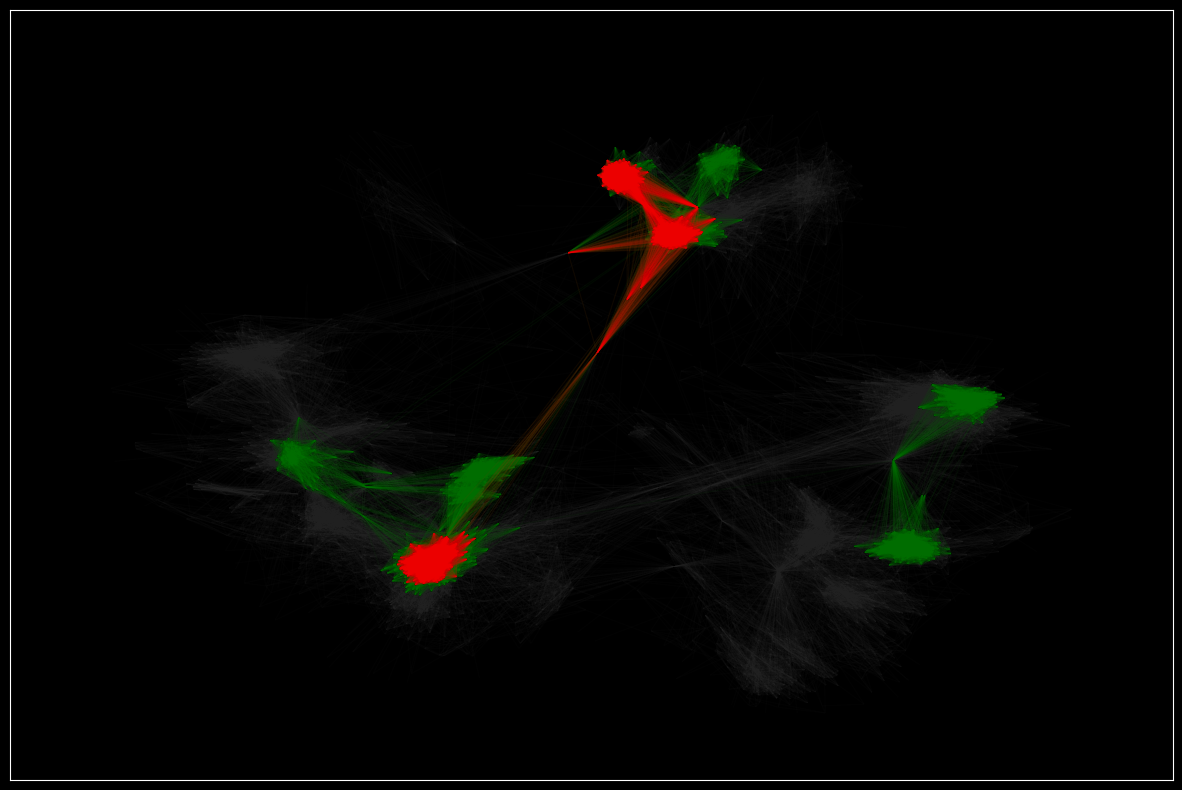

In [24]:
plt.show()